In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py
import seaborn as sns

import bioframe as bf

In [2]:
from akita_utils.dna_utils import scan_motif, dna_1hot
from akita_utils.format_io import read_jaspar_to_numpy

2023-09-26 16:28:22.510327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2023-09-26 16:28:22.510366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# from akita_utils.format_io import read_rmsk
# from akita_utils.tsv_gen_utils import filter_by_overlap_num

from io import StringIO

def read_rmsk(rmsk_file="/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz"):
    
    """reads a data frame containing repeatable elements and renames columns specifying genomic intervals to standard: chrom, start, end, used in thie repo."""
    
    rmsk_cols = list(
        pd.read_csv(
            StringIO(
                """bin swScore milliDiv milliDel milliIns genoName genoStart genoEnd genoLeft strand repName repClass repFamily repStart repEnd repLeft id"""
            ),
            sep=" ",
        )
    )

    rmsk = pd.read_table(
        rmsk_file,
        names=rmsk_cols,
    )
    
    rmsk.rename(
        columns={"genoName": "chrom", "genoStart": "start", "genoEnd": "end"},
        inplace=True,
    )
    
    return rmsk

def filter_by_overlap_num(
    working_df,
    filter_df,
    expand_window=60,
    working_df_cols=["chrom","start","end"],
    filter_df_cols=["chrom","start","end"],
    max_overlap_num=0):
    
    """
    Filter out rows from working_df that overlap entries in filter_df above given threshold.

    Parameters
    -----------
    working_df : dataFrame
        First set of genomic intervals.
    filter_df : dataFrame
        Second set of genomic intervals.
    expand_window : int
        Indicates how big window around the given genomic intervals should be taken into account.
    working_df_cols : list
        Columns specifying genomic intervals in the working_df.
    filter_df_cols : list
        Columns specifying genomic intervals in the filter_df.
    max_overlap_num : int
        All the rows with number of overlaps above this threshold will be filtered out.
        
    Returns
    --------
    working_df : dataFrame
        Subset of working_df that do not have overlaps with filter_df above given threshold.

    """
    
    filter_df = bf.expand(filter_df, pad=expand_window)
    
    working_df = bf.count_overlaps(working_df, filter_df[filter_df_cols], cols1=working_df_cols)
    
    working_df = working_df.iloc[working_df["count"].values <= max_overlap_num]
    working_df.reset_index(inplace=True, drop=True)

    return working_df

In [4]:
genome_file = "/project/fudenber_735/genomes/mm10/mm10.fa"

# reading tsv with all mouse motifs (overlapping boundaries)

In [5]:
all_ctcf_path = "/project/fudenber_735/tensorflow_models/akita/v2/analysis/to_insert_boundaries.motifs.ctcf.mm10.tsv"

In [6]:
df = pd.read_csv(all_ctcf_path, sep="\t")

### Since the set of motifs is the same for all backgrounds, I'd focus on a subset of the table corresponding to the 0th background

In [7]:
df = df[df["background_index"] == 0]

In [8]:
columns_to_keep = ["boundary_index", "chrom", "boundary_end", "index", "num_ctcf", "span", "boundary_start", "strand", "start", "end"]
df = df[columns_to_keep]

In [9]:
df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286
1,0,chr1,4410000,1,2,4405891-4405910,4400000,+,4405891,4405910
2,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074
3,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199
4,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886
...,...,...,...,...,...,...,...,...,...,...
18136,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695
18137,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409
18138,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176
18139,4473,chr19,59780000,26382,3,59770474-59770493,59770000,+,59770474,59770493


In [10]:
seq_id = []

for seq_index in range(len(df)):
    seq_id.append(seq_index)

df["seq_id"] = seq_id

In [11]:
df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,0
1,0,chr1,4410000,1,2,4405891-4405910,4400000,+,4405891,4405910,1
2,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,2
3,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,3
4,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,4
...,...,...,...,...,...,...,...,...,...,...,...
18136,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,18136
18137,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,18137
18138,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,18138
18139,4473,chr19,59780000,26382,3,59770474-59770493,59770000,+,59770474,59770493,18139


# Scanning CTCF motis in annotated genome intervals (+ flanks)

In [12]:
# reading CTCF motif from the jaspar file
motif_matrix = read_jaspar_to_numpy()

In [13]:
def get_forward_score(s, flank_bp=20):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom, s.start - flank_bp, s.end + flank_bp).upper())
    
    max_forward_score = scan_motif(dna, motif_matrix, strand="forward").max()
    
    return max_forward_score
    

In [14]:
def get_reverse_score(s, flank_bp=20):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom, s.start - flank_bp, s.end + flank_bp).upper())
    
    max_reverse_score = scan_motif(dna, motif_matrix, strand="reverse").max()
    
    return max_reverse_score
    

In [15]:
def get_scan_strand(s):
    
    if s.forward_scan >= s.reverse_scan:
        return "+"
    else:
        return "-"

In [16]:
def check_mismatch(s):
    if s.strand != s.scan_strand:
        return 1
    else:
        return 0


In [17]:
def get_rf_diff(s):
    diff = s.forward_scan - s.reverse_scan
    if diff >= 0:
        return diff
    else:
        return -1 * diff

In [18]:
genome_open = pysam.Fastafile(genome_file)

In [19]:
df.loc[:, ("forward_scan")] = df.apply(get_forward_score, axis=1)

2023-09-26 16:28:52.318498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2023-09-26 16:28:52.318530: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-26 16:28:52.318555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b02-11.hpc.usc.edu): /proc/driver/nvidia/version does not exist
2023-09-26 16:28:52.318858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
df.loc[:, ("reverse_scan")] = df.apply(get_reverse_score, axis=1)

In [21]:
df.loc[:, ("scan_strand")] = df.apply(get_scan_strand, axis=1)

In [22]:
df.loc[:, ("mismatch")] = df.apply(check_mismatch, axis=1)

In [23]:
df.loc[:, ("rf_diff")] = df.apply(get_rf_diff, axis=1)

In [24]:
df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,0,8.833119,9.756612,-,0,0.923493
1,0,chr1,4410000,1,2,4405891-4405910,4400000,+,4405891,4405910,1,9.647219,7.433492,+,0,2.213728
2,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,2,12.298969,9.266757,+,0,3.032212
3,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,3,7.595611,9.879084,-,0,2.283473
4,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,4,9.718778,8.000881,+,0,1.717897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18136,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,18136,7.310280,10.353126,-,0,3.042846
18137,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,18137,12.006318,8.295092,+,0,3.711225
18138,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,18138,8.170017,9.287240,-,0,1.117223
18139,4473,chr19,59780000,26382,3,59770474-59770493,59770000,+,59770474,59770493,18139,9.801126,8.496352,+,0,1.304775


### Do we have any sites with mismatches?

In [25]:
mismatch_df = df[df["mismatch"] == 1]

In [26]:
mismatch_df 

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff
22,4,chr1,6200000,30,5,6196777-6196796,6190000,-,6196777,6196796,22,9.940797,9.403333,+,1,0.537464
35,9,chr1,9550000,51,13,9541425-9541444,9540000,+,9541425,9541444,35,10.280726,10.320473,-,1,0.039747
37,9,chr1,9550000,53,13,9541481-9541500,9540000,+,9541481,9541500,37,10.159529,10.320473,-,1,0.160944
263,80,chr1,46770000,405,4,46769511-46769530,46760000,-,46769511,46769530,263,10.942715,10.144471,+,1,0.798244
278,86,chr1,50930000,431,5,50924962-50924981,50920000,+,50924962,50924981,278,10.047224,10.172300,-,1,0.125076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17959,4435,chr19,40240000,26128,10,40232867-40232886,40230000,-,40232867,40232886,17959,10.527751,10.295849,+,1,0.231901
18040,4450,chr19,47180000,26238,15,47174677-47174696,47170000,-,47174677,47174696,18040,11.337801,9.892838,+,1,1.444963
18044,4450,chr19,47180000,26242,15,47178158-47178177,47170000,+,47178158,47178177,18044,9.497453,9.814393,-,1,0.316940
18048,4450,chr19,47180000,26246,15,47179638-47179657,47170000,-,47179638,47179657,18048,9.929854,9.854858,+,1,0.074996


### Let's check distribuition of rf scores (absolute difference between forward and reverse scores)

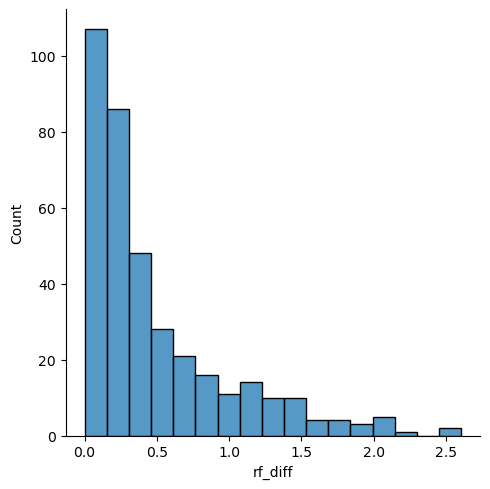

In [27]:
sns.displot(mismatch_df , x="rf_diff")

In [28]:
len(mismatch_df[mismatch_df["rf_diff"] > 0.9])

65

**Observation:** The difference between forward and reverse scores is small for majority of sites. Although differences in scores can also be relatively high and we may consider flipping the strand for sites with rf_diff above some threshold. 

### The "strand" column (coordinates of all CTCF-binding sites actually) is taken from the jasper file (downloaded from the jaspar database)
### Let's check which strand column in the jaspar tsv

In [29]:
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"

In [30]:
jaspar_df = bf.read_table(jaspar_file, schema="jaspar")

In [ ]:
# jaspar_df

In [ ]:
# mismatch_df

In [31]:
jaspar_overlap = bf.overlap(mismatch_df, jaspar_df, how="inner", suffixes=("_mis","_jaspar"))

In [32]:
jaspar_overlap_high = jaspar_overlap[jaspar_overlap["rf_diff_mis"] > 0.9]
jaspar_overlap_high = jaspar_overlap_high.sort_values(by = "start_mis")

In [33]:
jaspar_overlap_high.head(20)

,boundary_index_mis,chrom_mis,boundary_end_mis,num_ctcf_mis,span_mis,boundary_start_mis,strand_mis,start_mis,end_mis,seq_id_mis,...,scan_strand_mis,mismatch_mis,rf_diff_mis,chrom_jaspar,start_jaspar,end_jaspar,name_jaspar,score_jaspar,pval_jaspar,strand_jaspar
384,2300,chr9,13200000,6,13195442-13195461,13190000,+,13195442,13195461,9205,...,-,1,1.285078,chr9,13195439,13195458,CTCF,899,601,-
352,2300,chr9,13200000,6,13195442-13195461,13190000,+,13195442,13195461,9205,...,-,1,1.285078,chr9,13195442,13195461,CTCF,801,386,+
349,3062,chr12,17560000,5,17554309-17554328,17550000,-,17554309,17554328,12548,...,+,1,2.604811,chr12,17554295,17554314,CTCF,976,903,+
335,3062,chr12,17560000,5,17554309-17554328,17550000,-,17554309,17554328,12548,...,+,1,2.604811,chr12,17554309,17554328,CTCF,804,392,-
181,3470,chr14,20080000,5,20070814-20070833,20070000,+,20070814,20070833,14102,...,-,1,1.458552,chr14,20070814,20070833,CTCF,812,406,+
198,3470,chr14,20080000,5,20070814-20070833,20070000,+,20070814,20070833,14102,...,-,1,1.458552,chr14,20070812,20070831,CTCF,899,602,-
143,4402,chr19,24290000,5,24280611-24280630,24280000,+,24280611,24280630,17835,...,-,1,2.053448,chr19,24280611,24280630,CTCF,824,430,+
153,4402,chr19,24290000,5,24280611-24280630,24280000,+,24280611,24280630,17835,...,-,1,2.053448,chr19,24280609,24280628,CTCF,977,910,-
607,411,chr2,27780000,9,27772064-27772083,27770000,-,27772064,27772083,1496,...,+,1,1.319405,chr2,27772064,27772083,CTCF,820,421,-
608,411,chr2,27780000,9,27772064-27772083,27770000,-,27772064,27772083,1496,...,+,1,1.319405,chr2,27772069,27772088,CTCF,891,581,+


In [34]:
jaspar_overlap_high.tail(20)

,boundary_index_mis,chrom_mis,boundary_end_mis,num_ctcf_mis,span_mis,boundary_start_mis,strand_mis,start_mis,end_mis,seq_id_mis,...,scan_strand_mis,mismatch_mis,rf_diff_mis,chrom_jaspar,start_jaspar,end_jaspar,name_jaspar,score_jaspar,pval_jaspar,strand_jaspar
315,1776,chr6,132600000,6,132599905-132599924,132590000,-,132599905,132599924,6903,...,+,1,1.051478,chr6,132599905,132599924,CTCF,819,419,-
318,1776,chr6,132600000,6,132599947-132599966,132590000,-,132599947,132599966,6905,...,+,1,1.051478,chr6,132599949,132599968,CTCF,846,473,+
317,1776,chr6,132600000,6,132599947-132599966,132590000,-,132599947,132599966,6905,...,+,1,1.051478,chr6,132599947,132599966,CTCF,819,419,-
320,1776,chr6,132600000,6,132599989-132600008,132590000,-,132599989,132600008,6907,...,+,1,1.051478,chr6,132599991,132600010,CTCF,846,473,+
319,1776,chr6,132600000,6,132599989-132600008,132590000,-,132599989,132600008,6907,...,+,1,1.051478,chr6,132599989,132600008,CTCF,819,419,-
436,1229,chr4,133580000,12,133572149-133572168,133570000,+,133572149,133572168,4640,...,-,1,0.958797,chr4,133572146,133572165,CTCF,870,529,-
420,1229,chr4,133580000,12,133572149-133572168,133570000,+,133572149,133572168,4640,...,-,1,0.958797,chr4,133572149,133572168,CTCF,818,417,+
276,2039,chr7,139600000,10,139597206-139597225,139590000,-,139597206,139597225,8110,...,+,1,1.328744,chr7,139597211,139597230,CTCF,873,534,+
275,2039,chr7,139600000,10,139597206-139597225,139590000,-,139597206,139597225,8110,...,+,1,1.328744,chr7,139597206,139597225,CTCF,806,396,-
438,1258,chr4,151900000,6,151893426-151893445,151890000,+,151893426,151893445,4822,...,-,1,1.110730,chr4,151893424,151893443,CTCF,851,485,-


Now, the "strand_mis" column is the strand we had initially in the tsv file, while the "strand_jaspar" column is the strand in the jaspar tsv.   

**Note**, in the jaspar file there are two rows with different strands corresponding to one row in our tsv. Jasper coordinates differ by a few bps. This means that the scanning from both directions give scores above threshold and both motifs are reported, although our tsv has information only about one of them (likely, the weaker one).   

**Question**, However, there is additional step of filtering out overlapping CTCF-binding sites. Why those CTCFs are not filtered out if they obviously overlap and the strand column does not matter in the filtering out procedure.


# What is wrong with the filtering out step?

## Checking with filter_by_overlap_num

## CTCF overlap

In [35]:
filtered_df = filter_by_overlap_num(df,
                    filter_df=jaspar_df,
                     max_overlap_num=1)

In [36]:
len(df) - len(filtered_df)

2351

2351 ctcf sites have been filtered out and will be restricted from insertion experiment.
(even though, we have data for disruption experiment for all those mouse sites)

In [37]:
filtered_df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff,count
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,0,8.833119,9.756612,-,0,0.923493,1
1,0,chr1,4410000,1,2,4405891-4405910,4400000,+,4405891,4405910,1,9.647219,7.433492,+,0,2.213728,1
2,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,2,12.298969,9.266757,+,0,3.032212,1
3,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,3,7.595611,9.879084,-,0,2.283473,1
4,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,4,9.718778,8.000881,+,0,1.717897,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15785,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,18136,7.310280,10.353126,-,0,3.042846,1
15786,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,18137,12.006318,8.295092,+,0,3.711225,1
15787,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,18138,8.170017,9.287240,-,0,1.117223,1
15788,4473,chr19,59780000,26382,3,59770474-59770493,59770000,+,59770474,59770493,18139,9.801126,8.496352,+,0,1.304775,1


## RMSK overlap

In [38]:
rmsk_file = "/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz"

In [39]:
rmsk_df = read_rmsk(rmsk_file)

In [42]:
filtered_df = filter_by_overlap_num(filtered_df,
                        rmsk_df,
                        expand_window=20,
                        working_df_cols = ["chrom","start","end"])

In [43]:
filtered_df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff,count,count
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,0,8.833119,9.756612,-,0,0.923493,1,0
1,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,2,12.298969,9.266757,+,0,3.032212,1,0
2,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,3,7.595611,9.879084,-,0,2.283473,1,0
3,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,4,9.718778,8.000881,+,0,1.717897,1,0
4,1,chr1,4780000,7,10,4773435-4773454,4770000,+,4773435,4773454,5,9.707200,8.182703,+,0,1.524497,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,4472,chr19,59390000,26376,10,59388426-59388445,59380000,+,59388426,59388445,18135,9.676253,8.052074,+,0,1.624179,1,0
7556,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,18136,7.310280,10.353126,-,0,3.042846,1,0
7557,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,18137,12.006318,8.295092,+,0,3.711225,1,0
7558,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,18138,8.170017,9.287240,-,0,1.117223,1,0


## Check: have all of mismatched sites been filtered out?

In [44]:
mismatch_filter_df = filtered_df[filtered_df["mismatch"] == 1]

In [45]:
len(mismatch_filter_df)

54

In [46]:
filtered_jaspar_overlap = bf.overlap(mismatch_filter_df, jaspar_df, how="inner", suffixes=("_mis","_jaspar"))

In [ ]:
# filtered_jaspar_overlap 

In [47]:
filtered_jaspar_overlap = filtered_jaspar_overlap.sort_values(by = "start_mis")

In [48]:
filtered_jaspar_overlap

,boundary_index_mis,chrom_mis,boundary_end_mis,num_ctcf_mis,span_mis,boundary_start_mis,strand_mis,start_mis,end_mis,seq_id_mis,...,rf_diff_mis,count_mis,count_mis,chrom_jaspar,start_jaspar,end_jaspar,name_jaspar,score_jaspar,pval_jaspar,strand_jaspar
38,3832,chr16,3750000,6,3743928-3743947,3740000,-,3743928,3743947,15581,...,0.097281,1,0,chr16,3743928,3743947,CTCF,807,398,-
50,363,chr2,3850000,4,3840133-3840152,3840000,-,3840133,3840152,1323,...,0.160907,1,0,chr2,3840133,3840152,CTCF,834,449,-
33,4187,chr18,5160000,7,5157953-5157972,5150000,-,5157953,5157972,16972,...,0.364334,1,0,chr18,5157953,5157972,CTCF,805,394,-
7,2776,chr11,5960000,6,5956078-5956097,5950000,-,5956078,5956097,11238,...,0.046314,1,0,chr11,5956078,5956097,CTCF,812,406,-
43,725,chr3,11090000,1,11083624-11083643,11080000,-,11083624,11083643,2759,...,0.213997,1,0,chr3,11083624,11083643,CTCF,809,402,-
40,2073,chr8,16720000,5,16716934-16716953,16710000,+,16716934,16716953,8281,...,0.216165,1,0,chr8,16716934,16716953,CTCF,807,398,+
51,392,chr2,18230000,1,18221059-18221078,18220000,-,18221059,18221078,1429,...,0.301935,1,0,chr2,18221059,18221078,CTCF,818,418,-
41,2077,chr8,18950000,4,18942052-18942071,18940000,+,18942052,18942071,8294,...,0.027673,1,0,chr8,18942052,18942071,CTCF,804,391,+
34,3270,chr13,23770000,4,23764587-23764606,23760000,-,23764587,23764606,13326,...,0.198875,1,0,chr13,23764587,23764606,CTCF,802,389,-
12,3486,chr14,28520000,7,28519411-28519430,28510000,+,28519411,28519430,14172,...,0.206585,1,0,chr14,28519411,28519430,CTCF,812,407,+


In [49]:
len(filtered_jaspar_overlap.start_mis.unique())

54

In [50]:
len(filtered_jaspar_overlap.start_jaspar.unique())

54

## Let's filter them out for now and save the df for dot vs. boundary experiment

In [55]:
no_mismatch_filtered_df = filtered_df[filtered_df["mismatch"] == 0]

In [56]:
no_mismatch_filtered_df

,boundary_index,chrom,boundary_end,index,num_ctcf,span,boundary_start,strand,start,end,seq_id,forward_scan,reverse_scan,scan_strand,mismatch,rf_diff,count,count
0,0,chr1,4410000,0,2,4403267-4403286,4400000,-,4403267,4403286,0,8.833119,9.756612,-,0,0.923493,1,0
1,1,chr1,4780000,4,10,4770055-4770074,4770000,+,4770055,4770074,2,12.298969,9.266757,+,0,3.032212,1,0
2,1,chr1,4780000,5,10,4770180-4770199,4770000,-,4770180,4770199,3,7.595611,9.879084,-,0,2.283473,1,0
3,1,chr1,4780000,6,10,4770867-4770886,4770000,+,4770867,4770886,4,9.718778,8.000881,+,0,1.717897,1,0
4,1,chr1,4780000,7,10,4773435-4773454,4770000,+,4773435,4773454,5,9.707200,8.182703,+,0,1.524497,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,4472,chr19,59390000,26376,10,59388426-59388445,59380000,+,59388426,59388445,18135,9.676253,8.052074,+,0,1.624179,1,0
7556,4472,chr19,59390000,26377,10,59388676-59388695,59380000,-,59388676,59388695,18136,7.310280,10.353126,-,0,3.042846,1,0
7557,4472,chr19,59390000,26378,10,59389390-59389409,59380000,+,59389390,59389409,18137,12.006318,8.295092,+,0,3.711225,1,0
7558,4473,chr19,59780000,26381,3,59770157-59770176,59770000,-,59770157,59770176,18138,8.170017,9.287240,-,0,1.117223,1,0


In [57]:
no_mismatch_filtered_df = no_mismatch_filtered_df[columns_to_keep]

In [58]:
no_mismatch_filtered_df.to_csv("./filtered_base_mouse_ctcf.tsv", sep = "\t", index=False)

## Why there are still mismatches?

## The difference is we filter windows with flanks around, and jasper doens't do it. Do we stil have mismatches when sites are scanned without flanks

In [60]:
def get_forward_score_no_flanks(s):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom_mis, s.start_mis, s.end_mis).upper())
    
    max_forward_score = scan_motif(dna, motif_matrix, strand="forward").max()
    
    return max_forward_score

In [61]:
def get_reverse_score_no_flanks(s):
    
    motif_matrix = read_jaspar_to_numpy()
    dna = dna_1hot(genome_open.fetch(s.chrom_mis, s.start_mis, s.end_mis).upper())
    
    max_reverse_score = scan_motif(dna, motif_matrix, strand="reverse").max()
    
    return max_reverse_score

In [62]:
filtered_jaspar_overlap["nf_forward"] = filtered_jaspar_overlap.apply(get_forward_score_no_flanks, axis=1)

In [63]:
filtered_jaspar_overlap["nf_reverse"] = filtered_jaspar_overlap.apply(get_reverse_score_no_flanks, axis=1)

In [64]:
filtered_jaspar_overlap["nf_forward_reverse"] = filtered_jaspar_overlap["nf_forward"] - filtered_jaspar_overlap["nf_reverse"]

In [65]:
def get_scan_strand_no_flanks(s):
    
    if s.nf_forward >= s.nf_reverse:
        return "+"
    else:
        return "-"

In [66]:
filtered_jaspar_overlap["nf_strand_scan"] = filtered_jaspar_overlap.apply(get_scan_strand_no_flanks, axis=1)

In [67]:
filtered_jaspar_overlap[filtered_jaspar_overlap["nf_strand_scan"] != filtered_jaspar_overlap["strand_jaspar"]]

,boundary_index_mis,chrom_mis,boundary_end_mis,num_ctcf_mis,span_mis,boundary_start_mis,strand_mis,start_mis,end_mis,seq_id_mis,...,start_jaspar,end_jaspar,name_jaspar,score_jaspar,pval_jaspar,strand_jaspar,nf_forward,nf_reverse,nf_forward_reverse,nf_strand_scan
10,2605,chr10,41300000,7,41291282-41291301,41290000,-,41291282,41291301,10517,...,41291282,41291301,CTCF,803,390,-,9.503508,9.277279,0.226229,+
36,3324,chr13,49760000,3,49757470-49757489,49750000,+,49757470,49757489,13545,...,49757470,49757489,CTCF,835,451,+,9.509056,9.552637,-0.043581,-
30,2475,chr9,96890000,10,96887023-96887042,96880000,-,96887023,96887042,9994,...,96887023,96887042,CTCF,805,393,-,9.161618,8.983223,0.178395,+
16,1456,chr5,112430000,9,112422808-112422827,112420000,-,112422808,112422827,5563,...,112422808,112422827,CTCF,801,387,-,9.493761,9.409827,0.083933,+
53,663,chr2,154630000,7,154624162-154624181,154620000,+,154624162,154624181,2419,...,154624162,154624181,CTCF,829,440,+,9.699041,9.952575,-0.253533,-


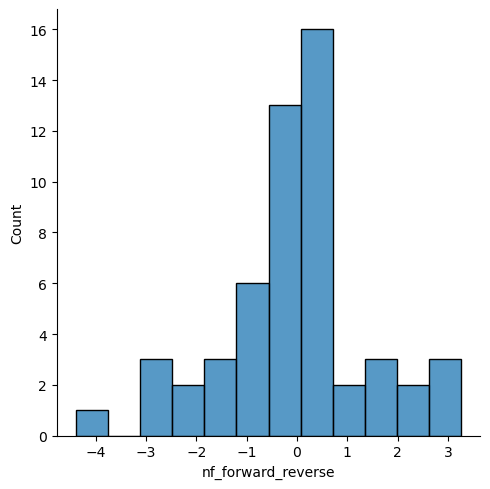

In [68]:
sns.displot(filtered_jaspar_overlap , x="nf_forward_reverse")

In [70]:
filtered_jaspar_overlap.to_csv("./filtered_base_mouse_ctcf_mismatched.tsv", sep = "\t", index=False)